**Table of contents**<a id='toc0_'></a>    
- [Loading the data](#toc1_1_1_1_)    
- [Overview of Cable Roads](#toc1_1_1_2_)    
- [Single CR with Relief](#toc1_1_1_3_)    
- [The Influence of Pulling Force on Slope](#toc1_1_1_4_)    
- [Forces on Anchor Tree and Tower Change According to Force and Angle](#toc1_1_1_5_)    
- [Resulting Force on Support per Angle and Incoming Force](#toc1_1_1_6_)    
- [Surface Plots of Mechanical Functions](#toc1_1_1_7_)    
- [Experimental Code Execution Visualization](#toc1_1_1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

#### <a id='toc1_1_1_1_'></a>[Loading the data](#toc0_)

In [96]:
# Package Imports
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

from importlib import reload

from ipywidgets import interact, FloatSlider, IntSlider

import plotly.graph_objects as go
import plotly.express as px
from plotly_gif import GIF, capture
from IPython.display import Image

%matplotlib widget

# Importing my modules
from src import data_loading, plotting, geometry_operations, optimization_functions, geometry_utilities, classes, cable_road_computation, mechanical_computations

In [97]:
%store -r line_gdf
%store -r height_gdf
%store -r tree_gdf
height_gdf_small = height_gdf.iloc[::100]

#### <a id='toc1_1_1_2_'></a>[Overview of Cable Roads](#toc0_)

In [98]:
fig = px.scatter_3d(x=height_gdf_small["x"], y=height_gdf_small["y"], z=height_gdf_small["elev"])
fig.update_traces(marker={'size': 0.75})
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), width=1000,height=800, title="Relief Map with possible Cable Roads")

for index in range(len(line_gdf)):
    start_point = Point(line_gdf.iloc[index].geometry.coords[0])
    end_point = (line_gdf.iloc[index].geometry.coords[1])
    supports = line_gdf.iloc[index].location_of_int_supports

    waypoints = [start_point, *supports, end_point]
    for previous, current in zip(waypoints, waypoints[1:]):
        

        # sample_line = line_gdf.iloc[index].geometry
        sample_line = LineString([previous, current])
        sample_cable_road = cable_road_computation.compute_initial_cable_road(sample_line,height_gdf)
        sample_cable_road.s_current_tension = 50000
        mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)
        x_sample_cr = [point[0] for point in sample_cable_road.floor_points]
        y_sample_cr = [point[1] for point in sample_cable_road.floor_points]
        z_floor_height = sample_cable_road.floor_height_below_line_points
        z_line_to_floor = sample_cable_road.floor_height_below_line_points+sample_cable_road.line_to_floor_distances
        z_sloped= sample_cable_road.floor_height_below_line_points+sample_cable_road.sloped_line_to_floor_distances

        # fig = px.line_3d(x=x_sample_cr, y=y_sample_cr, z=z_floor_height)
        # fig.add_trace(go.Scatter3d(x=x_sample_cr, y=y_sample_cr, z=z_line_to_floor, mode='lines', line=dict(color='red', width=2), name='Straight Line Distance'))
        fig.add_trace(go.Scatter3d(x=x_sample_cr, y=y_sample_cr, z=z_sloped, mode='lines', line=dict(width=3), name=f'Cable Road {index}'))

fig.show("notebook_connected")

In [99]:
# fig.write_html("02_Figures/All_Cable_Roads_with_Relief.html")

#### <a id='toc1_1_1_3_'></a>[Single CR with Relief](#toc0_)

In [156]:
line_gdf.columns

Index(['geometry', 'line_candidates', 'slope_deviation',
       'possible_support_trees', 'possible_anchor_triples',
       'max_supported_force', 'number_of_supports', 'location_of_int_supports',
       'current_tension', 'angle_between_supports', 'line_length'],
      dtype='object')

In [158]:
line_gdf.iloc[3].number_of_supports

0

In [201]:
# Setting up a sample cable road
sample_line = line_gdf.iloc[3].geometry
sample_cable_road = cable_road_computation.compute_initial_cable_road(sample_line,height_gdf)
sample_cable_road.s_current_tension = line_gdf.iloc[3].current_tension
mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)

157.00344309536246 c rope length


In [161]:
line_gdf.iloc[3]

geometry                    LINESTRING (-42.7310102431112 -14.247241143360...
line_candidates             LINESTRING (-42.7310102431112 -14.247241143360...
slope_deviation                                                     11.839983
possible_support_trees           Unnamed: 0.1  Unnamed: 0          x      ...
possible_anchor_triples     [[LINESTRING (-15.12792573 -26.16056076, -42.7...
max_supported_force                                      [1929977.3274897456]
number_of_supports                                                          0
location_of_int_supports                                                   []
current_tension                                                       85000.0
angle_between_supports                                              73.789534
line_length                                                        135.641444
Name: 3, dtype: object

In [165]:
reload(mechanical_computations)
mechanical_computations.compute_angle_between_supports(line_gdf.iloc[3].geometry, height_gdf)

30.238193487686885

In [203]:
reload(plotting)
plotting.plot_cr_relief(sample_cable_road, line_gdf,height_gdf,3)

26.762252076275953 c rope length


In [118]:
line_gdf.iloc[5].location_of_int_supports

In [119]:
# Setting up a sample cable road
sample_line = line_gdf.iloc[5].geometry
sample_cable_road = cable_road_computation.compute_initial_cable_road(sample_line,height_gdf)
sample_cable_road.s_current_tension = line_gdf.iloc[5].current_tension
mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)

In [150]:
reload(plotting)
plotting.plot_supported_cr_relief(sample_cable_road, line_gdf, height_gdf, 5)

#### <a id='toc1_1_1_4_'></a>[The Influence of Pulling Force on Slope](#toc0_)

In [103]:
from plotly.subplots import make_subplots

xmin, xmax, nx = 0.0, 100.0, 57
x = np.linspace(xmin, xmax, nx)

sample_cable_road.s_current_tension= 10
mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)
y = sample_cable_road.sloped_line_to_floor_distances

fig = go.FigureWidget(make_subplots(rows=1, cols=2))
sloped_ltfd = fig.add_scatter(x=x,
                      y=y, name="Distance to Floor")
sloped_ltfd_pestal = fig.add_scatter(x=x,
                      y=y, name="Pestal Load Path")


force = 5000
fig.add_trace(go.Bar(x=[0], y=[force], name="Force"),row=1, col=2)

fig.update_layout(title='Cable Road Slope',
                    xaxis_title='Width in Meters',
                    yaxis_title='Height in Meters',
                    yaxis=dict(range=[-300, 100]),
                    xaxis=dict(range=[-10,110]),
                    yaxis2=dict(range=[-10,20000]),
                    width=1200,height=400)

gif = GIF()

@capture(gif)
@interact(force=(0, 20000, 100))
def update(force=5000):
    sample_cable_road.s_current_tension = force
    mechanical_computations.calculate_sloped_line_to_floor_distances(sample_cable_road)
    y = sample_cable_road.sloped_line_to_floor_distances
    fig.data[0].y = y

    y_x_deflections_pestal = np.asarray([
        mechanical_computations.pestal_load_path(
            sample_cable_road, point
        )
        for point in sample_cable_road.points_along_line
    ])

    fig.data[1].y=-y_x_deflections_pestal
    fig.data[2].y=[force]
    fig.show()
    # return fig

fig.write_html("02_Figures/Cable_Road_Slope.html")
fig.show("notebook_connected")

interactive(children=(IntSlider(value=5000, description='force', max=20000, step=100), Output()), _dom_classes…

In [104]:
# n = 10000
# r1 = range(0, n, 100)
# r2 = range(n, 0, -100)
# for i in [*r1, *r2]:
#     # Changes the range of the data each step to make it look like a time series
#     update(i)

# # Create gif
# gif.create_gif()

In [105]:
# display(Image(data=open("02_Figures/Cable_Road_Slope.gif",'rb').read(), format='png'))

#### <a id='toc1_1_1_5_'></a>[Forces on Anchor Tree and Tower Change According to Force and Angle](#toc0_)

interactive(children=(IntSlider(value=10, description='index', max=30), FloatSlider(value=50000.0, description…

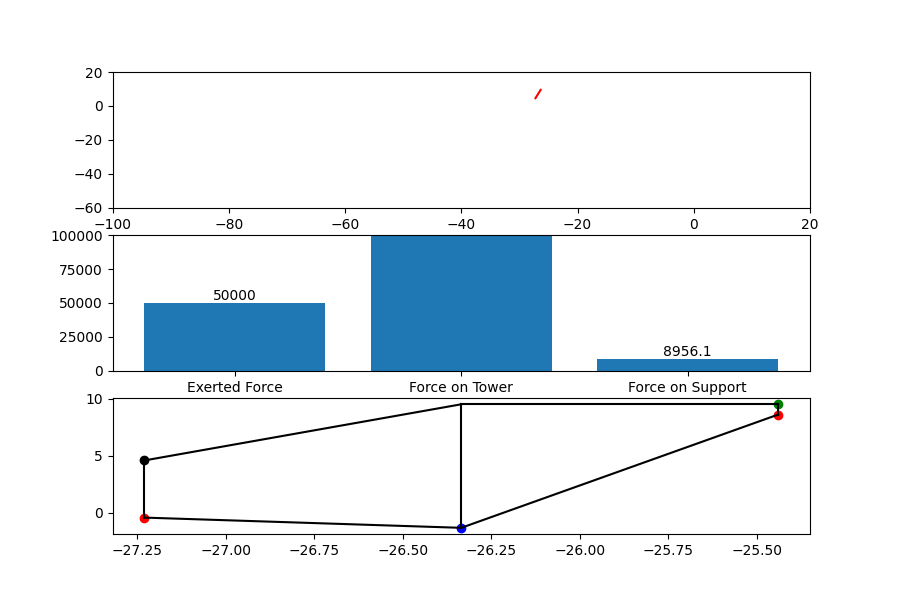

In [193]:
# Checking the anchor trees
reload(mechanical_computations)
reload(geometry_operations)

fig, (ax, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 6)) # two rows, one column

def plot_anchors_hold(index, force):
    sample_cable_road = cable_road_computation.compute_initial_cable_road(line_gdf.iloc[index].geometry,height_gdf, initial_tension=line_gdf.iloc[index].current_tension)
    sample_cable_road.s_current_tension = force
    mechanical_computations.check_if_tower_and_anchor_trees_hold(sample_cable_road,line_gdf.iloc[index].max_supported_force, line_gdf.iloc[index].possible_anchor_triples, height_gdf, ax, ax2, ax3)
    fig.canvas.draw()
    
interact(plot_anchors_hold, index=IntSlider(min=0, max=len(line_gdf), step=1, value=10), force=FloatSlider(min=50000, max=100000, step=1000, value=1000));

In [107]:
sample_cable_road.s_current_tension = 80000

angle centroids 3.255205001701653
force on cable 4544.512345216356
force on anchor 3026.738136510126
force on twoer 13458.802481432358
max supported force by anchor 1929977.3274897456
200000


True

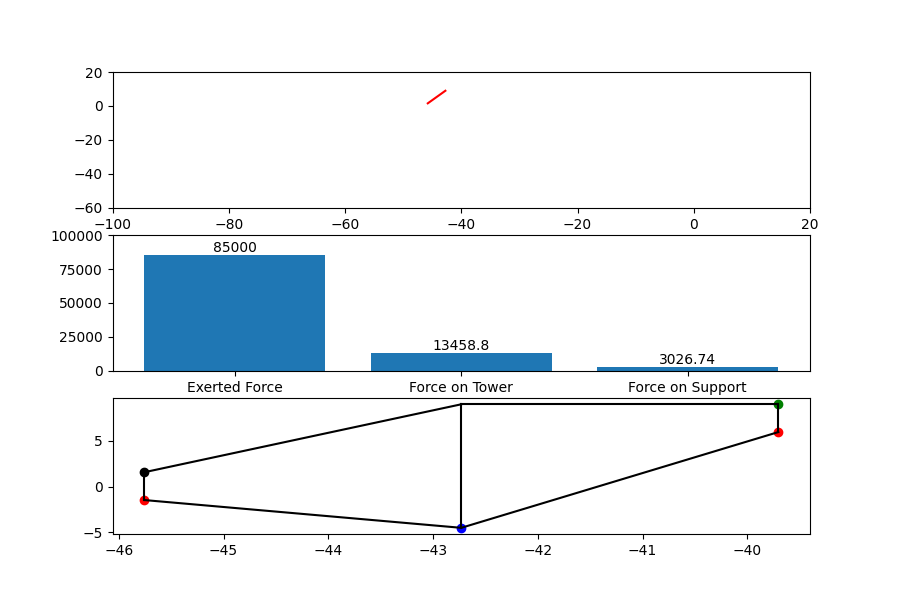

In [196]:
reload(mechanical_computations)
fig, (ax, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 6)) # two rows, one column
mechanical_computations.check_if_tower_and_anchor_trees_hold(sample_cable_road,line_gdf.iloc[1].max_supported_force, line_gdf.iloc[1].possible_anchor_triples, height_gdf, ax=ax, ax2=ax2, ax3=ax3)

In [171]:
reload(cable_road_computation)
reload(mechanical_computations)
cable_road_computation.compute_required_supports(line_gdf.iloc[3].geometry, line_gdf.iloc[3].possible_anchor_triples,line_gdf.iloc[3].max_supported_force,height_gdf,0, tree_gdf, [])

157.00344309536246 c rope length
initialize_line_tension
Tension to begin with is 85000.0
anchor_start_point_xy_distance 45.01945647656821


KeyboardInterrupt: 

In [205]:
sample_cable_road.start_point.coords.xy

(array('d', [-42.7310102431112]), array('d', [-14.247241143360652]))

In [206]:
line_gdf.iloc[3].geometry.coords.xy

(array('d', [-42.7310102431112, -82.7508461]),
 array('d', [-14.247241143360652, 115.3560539]))

angle centroids 3.826586046369082
force on cable 5341.929113995584


(5341.929113995584,
 <shapely.geometry.point.Point at 0x7f8464ba5a80>)

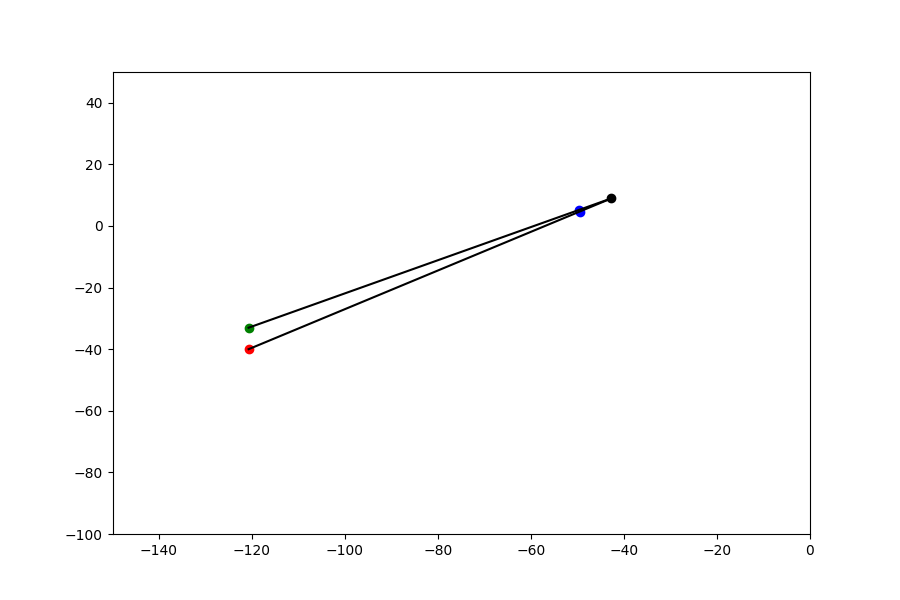

In [209]:
reload(mechanical_computations)
fig, (ax) = plt.subplots(1, 1, figsize=(9, 6)) # two rows, one column
mechanical_computations.compute_tension_sloped_vs_empty_cableroad(sample_cable_road, ax)

#### <a id='toc1_1_1_6_'></a>[Resulting Force on Support per Angle and Incoming Force](#toc0_)

In [151]:
unloaded_tangent_line_x = [0, 100000]
unloaded_tangent_line_y = [0, 0]
loaded_tangent_line_x = [0, 100000]
loaded_tangent_line_y = [0, 0]
force_on_support_x = [0, 0]
force_on_support_y = [0, 0]

fig = go.FigureWidget()
bar = fig.add_scatter(x=[*unloaded_tangent_line_x,*loaded_tangent_line_x,*force_on_support_x],
                      y=[*unloaded_tangent_line_y,*loaded_tangent_line_y,*force_on_support_y])

bar.update_layout(title='Resulting Force per Angle',xaxis_title='Force Vector on Support',
                    yaxis_title='Force Vector on Cable',
                    yaxis=dict(range=[-100000, 10]),
                    xaxis=dict(range=[-10,100000]))

gif = GIF()

@capture(gif)
@interact(force=(0, 100000, 1000), angle=(0, 50, 1))
def update(force=10000, angle=30):
    res = mechanical_computations.parallelverschiebung(force, angle)
    loaded_tangent_line_y=[0, -res]
    loaded_tangent_line_x=[0, force]
    force_on_support_x = [0, 0]
    force_on_support_y = [0, -res]
    fig.data[0].x=[*unloaded_tangent_line_x,*loaded_tangent_line_x,*force_on_support_x]
    fig.data[0].y=[*unloaded_tangent_line_y,*loaded_tangent_line_y,*force_on_support_y]
    fig.show()
    # return fig

# fig.write_html("Resulting_Force_per_Angle.html",full_html=True)
fig.show("notebook_connected")

interactive(children=(IntSlider(value=10000, description='force', max=100000, step=1000), IntSlider(value=30, …

In [81]:
# n = 10000
# r1 = range(0, n, 100)
# r2 = range(n, 0, -100)
# for i in [*r1, *r2]:
#     # Changes the range of the data each step to make it look like a time series
#     update(i)

# # Create gif
# gif.create_gif()

In [79]:
# display(Image(data=open("02_Figures/Resulting_Force_Parallelverschiebung.gif",'rb').read(), format='png'))

#### <a id='toc1_1_1_7_'></a>[Surface Plots of Mechanical Functions](#toc0_)

In [152]:
import plotly.graph_objects as go

x = np.arange(1,10,1)
y = np.arange(5,30,1)
X, Y = np.meshgrid(x, y)
Z = mechanical_computations.euler_knicklast(X,Y)

fig = go.Figure(data=[go.Surface(z=Z)])

fig.update_layout(title='Resulting Force Knicklast',scene = dict(
                    xaxis_title='Tree Diameter in Meters',
                    yaxis_title='Height of Attachment in Meters',
                    zaxis_title='Maximum Force in Newon'),
                    width=1200,height=600)
# fig.write_html("02_Figures/Resulting Force Knicklast.html")
fig.show("notebook_connected")

#### <a id='toc1_1_1_8_'></a>[Experimental Code Execution Visualization](#toc0_)

In [67]:
import plotly.graph_objects as go
import inspect

def create_call_graph(f):
    nodes = []
    edges = []
    visited = set()

    def add_node(node):
        if node not in nodes:
            nodes.append(node)

    def add_edge(source, target):
        edges.append({'source': nodes.index(source), 'target': nodes.index(target)})

    def traverse(obj):
        if inspect.isfunction(obj) and obj.__name__ != 'create_call_graph':
            add_node(obj)
            if obj not in visited:
                visited.add(obj)
                for caller in obj.__code__.co_names:
                    if caller != obj.__name__:
                        caller_obj = obj.__globals__.get(caller, None)
                        if caller_obj is not None:
                            add_node(caller_obj)
                            add_edge(caller_obj, obj)
                            traverse(caller_obj)

    traverse(f)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[node.__name__ for node in nodes]
        ),
        link=dict(
            source=[edge['source'] for edge in edges],
            target=[edge['target'] for edge in edges],
            value=[1] * len(edges)
        ))])

    fig.show()

    return nodes, edges

nodes, edges = create_call_graph(mechanical_computations.check_if_no_collisions_overall_line)


In [69]:
a = dict(
            source=[nodes[edge['source']].__name__ for edge in edges],
            target=[nodes[edge['target']].__name__ for edge in edges]
        )

b = list(zip(*a.values()))

import networkx as nx
import igviz as ig

def createDiGraph(nodes, edges):
    # Create a directed graph (digraph) object; i.e., a graph in which the edges
    # have a direction associated with them.
    G = nx.DiGraph()

    # Add nodes:
    # nodes = ['A', 'B', 'C', 'D', 'E']
    nodes = [node.__name__ for node in nodes]
    G.add_nodes_from(nodes)

    # Add edges or links between the nodes:
    # edges = [('A','B'), ('B','C'), ('B', 'D'), ('D', 'E')]
    G.add_edges_from(edges)
    return G

DG = createDiGraph(nodes, b)

ig.plot(DG,layout="kamada",)

/tmp/ipykernel_25129/3868554267.py:28: DeprecationWarning:

Argument `titlefont_size` is deprecated and will be removed in 0.6.0.



FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines',
              'text': [],
              'type': 'scatter',
              'uid': '95f52f48-0d17-4a55-940f-842d61cfa4b6',
              'x': [0.29418574362004235, 0.9943840832590664, None,
                    -0.22676114800165376, 0.29418574362004235, None,
                    -0.2208635402631829, 0.29418574362004235, None,
                    -0.4661292381955491, 0.29418574362004235, None,
                    -0.46910291860844366, 0.29418574362004235, None,
                    -0.39351376199535476, 0.29418574362004235, None,
                    -0.3309629945067411, -0.39351376199535476, None,
                    -0.3309629945067411, 0.33340426314192184, None,
                    0.33340426314192184, 0.9943840832590664, None,
                    0.4853595115498946, 0.9943840832590664, None],
              'y': [0.24199302753757082, -0.1386956524682232, Non